Let's take a look into our dataset

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("./dataset/processed_dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [ ]:
import pathlib
import numpy as np

data_dir = pathlib.Path("./dataset/processed_dataset/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

Prepare the data in order to load in into the model. The images are being rescaled into [0-1] values and also used some data augmentation because the images of the dataset are moved into the top left corner.
The images are loaded into batches with a size of 32 and grayscale mode.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=0.2,
                                    shear_range=0.2,
                                             zoom_range=0.1,
                                             width_shift_range=0.01,
                                             height_shift_range=0.01,
                                             horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

#Setup paths
train_dir = "./dataset/processed_dataset/train"
test_dir = "./dataset/processed_dataset/test"

#Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               color_mode="grayscale",
                                               target_size=(256,256),
                                               shuffle=True,
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               color_mode="grayscale",
                                               target_size=(256,256),
                                               class_mode="categorical",
                                               seed=42)

The first model uses three convolutional layers with ReLU activation and a MaxPooling layer after them. The last layer is a dense layer with 10 neurons, one for each class, and softmax activation because we're doing multi-class classification.

The optimizer is Adam with a learning rate of 0.001 (default)
We use accuracy as metrics

In [ ]:

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
    ])

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


Let's fit the model with 1 epoch because of google colab limits and save it after the train.

In [ ]:
history_1 = model_1.fit(train_data,
            epochs=1,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))
model_1.save('model1.keras')

Function to load and predict an image to test the model.

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  img = tf.reduce_mean(img[:, :, :3], axis=-1)
  return tf.expand_dims(img, -1)

In [ ]:
import matplotlib.pyplot as plt

def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports and image located at filename, makes aprediction with model
  and plots the image with the predicted class as the title
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename, 256)
  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  # Get the predicted class
  pred_class = class_names[pred[0].argmax()]
  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  plt.text(0, 250, f"Pred prob: {100*tf.reduce_max(pred)}")


Let's test the function with an image drawn on paint.

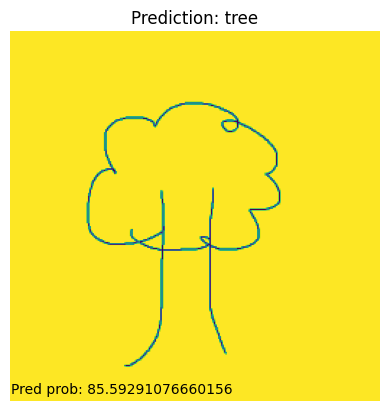

In [ ]:
pred_and_plot(model_1, "test.png")